In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import random_graph
import itertools
import collections
import pandas as pd
from pandas.plotting import parallel_coordinates
from matplotlib import rc
import functools
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import scipy.sparse as sparse
rc('text', usetex=True)

sns.set(font='serif', style='white')

In [2]:
with open('tmp/cuysq_6000_preserve3b_learnedseenlongd.json') as f:
    d = json.load(f)
    data = d['data'][1::]
    ancillary = d['ancillary'][0:-1]
    print(len(data), len(ancillary))
coords = random_graph.generate_sorted_grid_coords(16)

5 5


In [3]:
awake = lambda i: 1 if i in [0] else 0
just_relevant = lambda v: awake(v[0]) * int(v[1]!=0)
"""
def just_relevant(state):
    battery = state[1]
    status = state[0]
    if status == 0:
        state = 'awake'
    if status == 1:
        state = 'idle'
    if status == 2:
        state = 'deep'
    if battery==0:
        state = 'dead'
    return state#if status== 0
"""
tuplify = lambda d: [(k,just_relevant(v)) for k,v in sorted(d.items(), key=lambda i:int(i[0][1::]))]
tuplify_series = lambda lst:(tuplify(d) for d in lst)
def consecutive_pairs(lst_of_lsts):
    a, b = itertools.tee(lst_of_lsts)
    next(b, None)
    return zip(a,b)
def unroll(all_data):
    return itertools.chain(*[tuplify_series(s) for s in all_data])
def unroll_transitions(all_data):
    tuplified_series = (tuplify_series(s) for s in all_data)
    transitions = (consecutive_pairs(s) for s in tuplified_series)
    #return transitions
    return itertools.chain(*transitions)
def count_transitions(g):
    lst = list(g)
    total = len(lst)
    counted = collections.Counter(lst)
    return {k[1]:counts/total for k, counts in counted.items()}
def transition_matrix(all_data):
    transitions = unroll_transitions(data)
    hasher = lambda x,y: (json.dumps(x), json.dumps(y))
    hashable = [hasher(*i) for i in transitions]
    ordered = sorted(hashable, key = lambda i:i[0])
    grouped = {k:count_transitions(g) for k,g in 
               itertools.groupby(ordered, key = lambda i:i[0])}
    return grouped
def count_on_frequency(all_data):
    states = [collections.OrderedDict(state) for state in unroll(all_data)]
    df = pd.DataFrame(states)
    #print(df.head(5))
    return df.mean(axis=0).to_dict()
def find_most_common(all_data):
    states = unroll(data)
    hashable = [json.dumps(i) for i in states]
    total = len(hashable)
    counts = collections.Counter(hashable).most_common()
    return [(json.loads(x),y/total) for x,y in counts]
transitions = transition_matrix(data)
counts = find_most_common(data)
def add_count(x,y):
    x.append(('F',y))
    return x
just_points = [add_count(x,y) for x,y in counts]
def to_df(points):
    df = pd.DataFrame([collections.OrderedDict(t) for t in just_points])
    return df
df = to_df(just_points)
dict_data = [v for k,v in df.T.to_dict().items()]
#df.head(15)

In [4]:
def plot(data,coords,ax, num):
    #print(data)
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+5)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-5)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-5,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+5,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    s=250
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    ax.scatter([i[0] for i in coords],[i[1] for i in coords]
              ,facecolor='#ffffff',edgecolor='#525252', linewidth=1,s=s)
    name_to_num = lambda s:int(s[1::])
    active = [name_to_num(i) for i in data if data[i] == 1]
    active_coords= [coords[idx] for idx in active]
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)
    for idx, (x,y) in enumerate(coords):
        if (x,y) not in active_coords:
            ax.text(x,y, str(idx), color='#525252',horizontalalignment='center'
                    ,verticalalignment='center', fontsize=11)
    for idx, (x,y) in enumerate(active_coords):
        original_idx = coords.index((x,y))
        ax.text(x,y,str(original_idx), color='#ffffff', horizontalalignment='center'
                ,verticalalignment='center', fontsize=11)
    ax.scatter([i[0] for i in active_coords], [i[1] for i in active_coords]
              ,facecolor='#525252',edgecolor='#525252', linewidth=1,s=s)
    for line in horizs+verticals+top_extensions+bottom_extensions+left_extensions+right_extensions:
        ax.plot([x for x,y in line],[y for x,y in line], color ='#d9d9d9',zorder =0, linestyle ='--')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.text(15.5,-10,str(num+1)+')')
    return ax

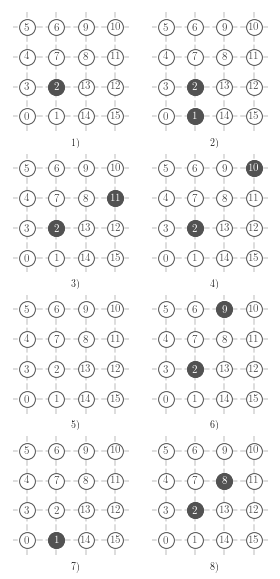

In [5]:
#fig,ax = plt.subplots(1)
fig, axarr = plt.subplots(4, 2)
fig.set_size_inches(4,8)
for idx, ax in enumerate(itertools.chain(*axarr)):
    plot(dict_data[idx], coords, ax, idx)
#plot(dict_data[0],coords,ax)
sns.despine(left=True, bottom=True)
fig.tight_layout()
#sns.despine()

In [6]:
def get_color(cmap, val, minval=0,maxval=1):
    assert minval<=val<=maxval
    factor = (maxval-minval)*255
    return cmap(int(factor*val))
def contrast_text(background):
    r,g,b,a = [int(255*i) for i in background]
    brightness = (r*299+g*587+b*114)/1000
    return "#ffffff" if brightness<175 else '#252525'
def heatplot(data, coords,ax, fig, vmin=0,vmax=1):
    #print(data)
    """
    data: {'S0':p0,'S1':p1...} where p1..pn is the probability of being in that state
    """
    xs =set([x for x,y in coords])
    ys = set([y for x,y in coords])
    top_coords = list(itertools.product(xs, [max(ys)]))
    top_extensions = [[(x,y),(x,y+5)] for x,y in top_coords]
    bottom_coords = list(itertools.product(xs, [min(ys)]))
    bottom_extensions = [[(x,y),(x,y-5)] for x,y in bottom_coords]
    right_coords= list(itertools.product([max(xs)], ys))
    left_coords = list(itertools.product([min(xs)], ys)) 
    left_extensions = [[(x,y),(x-5,y)] for x,y in left_coords]
    right_extensions = [[(x,y),(x+5,y)] for x,y in right_coords]
    verticals = [list(itertools.product([x],ys)) for x in xs]
    s=600
    horizs = [list(itertools.product(xs,[y])) for y in ys]
    name_to_num = lambda s:int(s[1::])
    stringifier = lambda s: str(s) if len(str(s))==2 else ' '+str(s)        
    cmap=plt.get_cmap("Greys")
    our_colors = functools.partial(get_color, cmap)
    ps = [data['S'+str(idx)] for idx,v in enumerate(coords)]
    #solars = [500*ancillary['S'+str(idx)] for idx, v in enumerate(coords)]
    sc = ax.scatter([x for x,y in coords],[y for x,y in coords],c=ps ,vmin=vmin,vmax=vmax,
               edgecolor='#525252', linewidth=1,s=s, cmap=cmap)
    #ax.scatter([x for x,y in coords],[y for x,y in coords],s=solars,
    #           edgecolor='#525252', linewidth=1)
    for idx,(x,y) in enumerate(coords):
        val = data['S'+str(idx)]
        color = our_colors(val)
        ax.text(x,y, str(idx), color=contrast_text(color),horizontalalignment='center'
                ,verticalalignment='center', fontsize=11)
    for line in horizs+verticals+top_extensions+bottom_extensions+left_extensions+right_extensions:
        ax.plot([x for x,y in line],[y for x,y in line], color ='#d9d9d9',zorder =0, linestyle ='--')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    #ax_cbar = fig.add_axes([1, 0.2, 0.1, 0.6])
    
    ax_cbar = fig.add_axes([0.2,0,0.6,0.1])
    cbar = plt.colorbar(sc, ax = ax_cbar, orientation='horizontal', fraction=1,label='Proportion of time active',
                        ticks=[0,0.2,0.4,0.6,0.8,1])
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(direction='out', length=2, width=0.5, colors='#525252',
              grid_color='#525252', grid_alpha=0.5)
    ax_cbar.axes.get_xaxis().set_visible(False)
    ax_cbar.axes.get_yaxis().set_visible(False)
    ax_cbar.set_yticklabels([])
    return ax

In [7]:
def avg_ancillary(anc):
    keys = [k for k in anc[0]]
    grouped_ancillary = {k:[] for k in keys}
    for item in anc:
        for k in keys:
            grouped_ancillary[k].append(item[k])
    avgs = {k:np.mean(v) for k,v in grouped_ancillary.items()}
    return avgs

In [8]:
CSS = """
.output {
    flex-direction: row;
}
"""
from IPython.display import display, HTML
HTML('<style>{}</style>'.format(CSS))

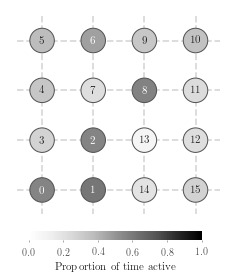

In [11]:
#fig, ax = plt.subplots(1)
#fig.set_size_inches(4,4)
idx1,idx2 = 0,5
freq_count = count_on_frequency(data[idx1:idx2])
avg_solar = avg_ancillary(ancillary[idx1:idx2])
#heatplot(avg_solar, coords, ax,fig,vmin=0.2,vmax=0.4)
#sns.despine(left=True, bottom=True)
fig2,ax2 = plt.subplots(1)
fig2.set_size_inches(4,4)
heatplot(freq_count, coords, ax2, fig2)
sns.despine(left=True, bottom=True)

In [12]:
def find_pairwise_correlations(states, relative=False):
    states = pd.DataFrame([collections.OrderedDict(i) for i in unroll(data)])
    total_states = len(states)
    keys = list(states.columns)
    dfs = {k:states[states[k]==1] for k in keys}
    if relative:
        totals = {k:v.mean(axis=0) for k,v in dfs.items()}
    else:
        totals = {k:v.sum(axis=0)/total_states for k,v in dfs.items()} 
    heat_array = np.asarray([v.values for k,v in 
                             sorted(totals.items(),
                                    key=lambda i:int(i[0][1::]))])
    return heat_array

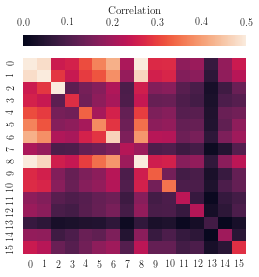

In [15]:
heat_array = find_pairwise_correlations(data, relative=False)
fig, ax = plt.subplots(1)
fig.set_size_inches(4,4.5)
ax = sns.heatmap(heat_array,ax=ax,vmin=0,vmax=0.5,
                 cbar_kws = dict(use_gridspec=False,location="top",label='Correlation'))

In [16]:
transition_sparse = transition_matrix(data)

In [17]:
transition_sparse[[s for s in set(transition_sparse)][0]]

{'[["S0", 0], ["S1", 0], ["S2", 1], ["S3", 0], ["S4", 0], ["S5", 0], ["S6", 0], ["S7", 0], ["S8", 0], ["S9", 0], ["S10", 1], ["S11", 0], ["S12", 0], ["S13", 0], ["S14", 0], ["S15", 0]]': 1.0}

In [18]:
def is_irreducible(sparsemat):
    check_irreducibility = np.linalg.matrix_power(sparsemat.todense(), 100000)
    return np.min(check_irreducibility)>0
def dict_to_sparsemat(d):
    all_states = set([k for k in d]+[v for k,vs in d.items() for v in vs])
    n= len(all_states)
    hashmap ={state:idx for idx, state in enumerate(all_states)}
    mtx = sparse.dok_matrix((n, n), dtype=np.float64)
    for state, destinations in d.items():
        state_idx = hashmap[state]
        for destination,p in destinations.items():
            destination_idx = hashmap[destination]
            mtx[state_idx, destination_idx] = p
    return hashmap, mtx
def stationary_distribution(sparsemat):
    vals, vecs = sparse.linalg.eigs(sparsemat.T, k=6)
    ind = vals.argsort()
    largest = np.array(vecs[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    probabilities = largest/norm
    largest_3_idx = probabilities.argsort()[::-1][0:10]
    return dict(zip(largest_3_idx, probabilities[largest_3_idx]))
def analyse(d):
    lookup, sparsemat = dict_to_sparsemat(transition_sparse)
    inverted_lookup = {v:k for k,v in lookup.items()}
    pagerank = stationary_distribution(sparsemat)
    res = {inverted_lookup[idx]:p for idx, p in pagerank.items()}
    most_common = [dict(json.loads(i)) for i in res]
    return most_common

In [19]:
lookup, sparsemat = dict_to_sparsemat(transition_sparse)

In [20]:
res = analyse(transition_sparse)

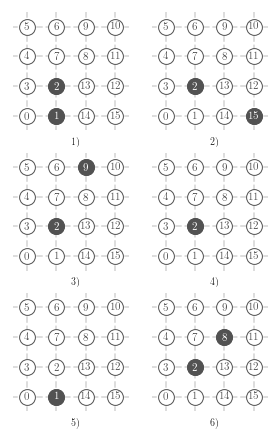

In [21]:
fig, axarr = plt.subplots(3, 2)
fig.set_size_inches(4,6)
for idx, ax in enumerate(itertools.chain(*axarr)):
    plot(res[idx], coords, ax, idx)
sns.despine(left=True, bottom=True)
fig.tight_layout()
#sns.despine()

In [30]:
def find_lookup_mode(moderank):
    copied = json.loads(json.dumps(moderank))
    f = copied.get('F')
    del copied['F']
    ordered = sorted([(k,int(v)) for k,v in copied.items()], key = lambda i:i[0])
    return json.dumps(ordered), f
def crosscheck_pagerank(dict_data, res):
    lookup = dict([find_lookup_mode(i) for i in dict_data])
    fmatted = sorted([(k,int(v)) for k,v in res.items()], key = lambda i:i[0])
    return lookup[json.dumps(fmatted)]

In [36]:
crosscheck_pagerank(dict_data,res[5])

0.0003125

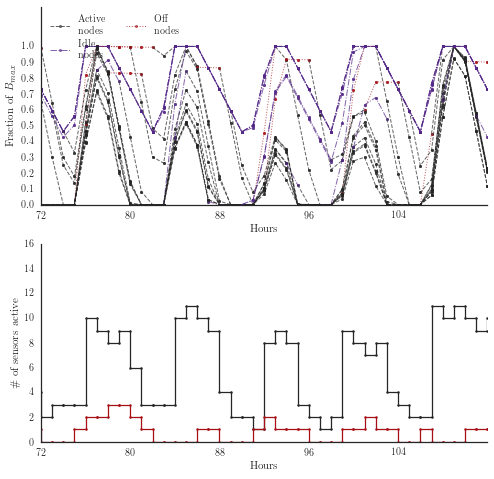

In [24]:
import copy,itertools
#with open('tmp/arcyn_5000_episodes_month.json') as f:
#    statetracelearned = json.load(f)
with open('tmp/cuysq_6000_preserve3b_learnedseenlongd.json') as f:#('tmp/fogdm_7000_testingnaiveseen.json') as f:
    statetracelearned = json.load(f)
def num_changes(d):
    any_changes =  {k:v for k,v in d.items() if v}
    return len(any_changes)
def plotthreeoptions(statetrace):
    run=2
    startday = 9
    periods = 8#in three hours 8 periods make a full day
    duration =5#days
    select = [startday*periods,(startday+duration)*periods]
    fulldata = statetrace['data'][run]
    data = statetrace['data'][run]#[0:select[1]+16]
    xs = list(range(len(fulldata)))#[0:select[1]+16]
    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(8,8)
    #fig, ax1 = plt.subplots(1)
    #fig.set_size_inches(8,4)
    def bit(i):
        res = 0 if int(i) in [1,2] else 1 
        return res
    for sensor in ['S'+str(i) for i in range(16)]:#['S0','S1','S2','S3']:
        sensordata = [i[sensor] for i in data]
        pairs = list(zip(sensordata,sensordata[1::]))
        battdata = [{'srcx':xs[idx],'status':src[0], 'src':src[1], 'dst':dst[1]}
                    for idx, (src,dst) in enumerate(pairs)]
        deepbattdata = copy.deepcopy(battdata)
        idlebattdata = copy.deepcopy(battdata)   
        onbattdata = copy.deepcopy(battdata)   
        for d in deepbattdata:
            if d['status'] in [0,1]:
                d['src'],d['dst'] = (np.nan, np.nan)
        for d in onbattdata:
            if d['status'] in [1,2]:
                d['src'],d['dst'] = (np.nan, np.nan)
        for d in idlebattdata:
            if d['status'] in [0,2]:
                d['src'],d['dst'] = (np.nan, np.nan)
        def unroller(d):
            return [(d['srcx'], d['src']), (d['srcx']+1, d['dst'])]
        def prepare(series):
            return list(itertools.chain(*[unroller(d) for d in series]))
        label1 = 'Active\nnodes'
        label2 = 'Idle\nnodes'
        label3 = 'Off\nnodes'
        ax1.plot([x for x,y in prepare(onbattdata)],[y for x,y in prepare(onbattdata)],
                 linestyle='--',linewidth=1, color ='#252525',marker='o'
                 , markersize=3, alpha=0.7, label=label1 if sensor=='S0' else '')
        ax1.plot([x for x,y in prepare(idlebattdata)],[y for x,y in prepare(idlebattdata)],
                 linestyle='-.',linewidth=1, color ="#542788",marker='o'
                 , markersize=3, alpha=0.7,label=label2 if sensor=='S0' else '')
        ax1.plot([x for x,y in prepare(deepbattdata)],[y for x,y in prepare(deepbattdata)],
                 linestyle=':',linewidth=1, color ="#a50f15",marker='o'
                 , markersize=3, alpha=0.7,label=label3 if sensor=='S0' else '')
    ticks = [i for i in range(select[0], select[1]) if i%8==0]
    ax1.set_xticks(ticks)
    ax2.set_xticks(ticks)
    ax1.set_xlim([select[0], select[1]])
    ax2.set_xlim([select[0], select[1]])
    count_on = lambda de: sum([v[0]==0 and v[1]!=0 for k,v in de.items()])#and v[1]!=0
    count_deep = lambda de: sum([v[0]==2 for k,v in de.items()])
    #ax2b = ax2.twinx()
    counts = [count_on(d) for d in data]
    deep_count = [count_deep(d) for d in data]
    ax2.plot(xs, counts, color = '#252525',drawstyle='steps-post', 
             linestyle= '-',markersize=2.5, marker='o', linewidth=1.25)
    ax2.plot(xs, deep_count, color = '#a50f15',drawstyle='steps-post', 
             linestyle= '-',markersize=2.5, marker='o', linewidth=1.25)
    ax2.set_ylabel('\# of sensors active')
    ax2.set_xlabel('Hours')
    ax1.set_xlabel('Hours')
    ax1.set_ylabel(r'Fraction of $B_{max}$')
    #sns.despine()
    ax1.set_ylim([0,12.5])
    ax2.set_ylim([0,16])
    ax1.set_yticks([i for i in range(0,11)])
    ax1.set_yticklabels([i/10 for i in ax1.get_yticks()])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax1.legend(loc='upper left', ncol=2)
    #ax1.legend(bbox_to_anchor=(1.2,0.5))#loc='lower right')
    #ax2.legend(bbox_to_anchor=(1.1,0.5))#loc='lower right')
    #fig.tight_layout()
    return fig,ax1, ax2
fig,ax1,ax2 = plotthreeoptions(statetracelearned)
#fig.savefig('timeseries_investigation.png',dpi=600)

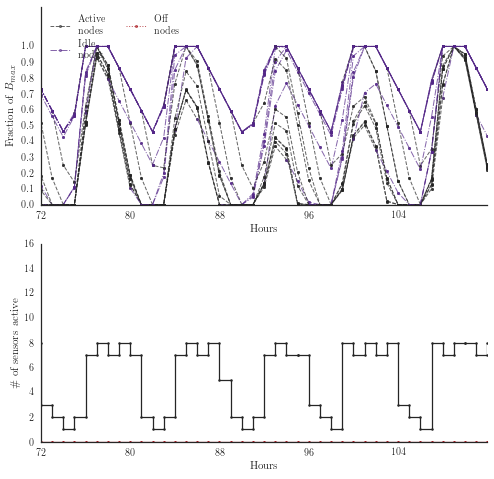

In [25]:
with open('tmp/wwvux_three_naive_seen.json') as f:
    statetracenaive = json.load(f)
f, a1,a2 = plotthreeoptions(statetracenaive)

In [1]:
statetrace = statetracelearned
fig, ax = plt.subplots(1)
fig.set_size_inches(3.5,8)
run=2
startday = 39
periods = 8#in three hours 8 periods make a full day
duration =5#days
select = [startday*periods,(startday+duration)*periods]
fulldata = statetrace['data'][run]
data = statetrace['data'][run]#[0:select[1]+16]
xs = list(range(len(fulldata)))#[0:select[1]+16]
flag0,flag1,flag2,flag3 = True, True,True,True
for i in range(16):
    #sensor = data['S'+str(idx)]
    ys = [i]*len(xs)
    for idxf, state in enumerate(data[select[0]:select[1]]):
        idx= select[0]+idxf                        
        sensorstate = state['S'+str(i)]
        status = sensorstate[0]
        battery = sensorstate[1]
        bit = 1 if battery>0 else 0
        if status == 0 and battery>0:
            label ='Active' if flag0 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#253494', linewidth=3,label=label)#battery/2)
            flag0 =False
        if status == 1 and battery>0:
            label ='Standby' if flag1 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#f05f40', linewidth=3*bit, linestyle='-',label=label)#battery/2)
            flag1 = False
        if status == 2 and battery>0:
            label = 'Deep sleep' if flag2 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#cb181d', linewidth=3*bit, linestyle=':',label=label)#battery/2)
            flag2 = False
        if battery == 0:
            label ='Dead' if flag3 else ''
            ax.plot([ys[idx], ys[idx+1]], [xs[idx],xs[idx+1]], color='#d9d9d9', linewidth=2,linestyle=':',label=label)#battery/2)
            flag3=False
sns.despine()
yticks = [i for i in range(select[0], select[1]) if i%8==0]
_ =ax.set_yticks(yticks)
ax.set_ylabel('Hour')
xticks = [i for i in range(16)]
_ =ax.set_xticks(xticks)
_ = ax.set_xlabel('Sensor \#')
_=ax.legend(bbox_to_anchor=(1.1,0.5))
#ax.set_ylim()

NameError: name 'statetracelearned' is not defined

In [ ]:
#cluster them somehow?